In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
data_dir_train = BATCH_SIZE_TRAIN = 'Fundus_Scanes_Sorted/Train'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 654 files belonging to 2 classes.


In [7]:
data_dir_test = BATCH_SIZE_TEST = 'Fundus_Scanes_Sorted/Validation'
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 164 files belonging to 2 classes.


In [8]:
import pandas as pd
train_label = pd.read_csv('glaucoma.csv')
y_train = train_label['Glaucoma']
train_label.head()
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: Glaucoma, dtype: int64

In [9]:
from pathlib import Path
from PIL import Image
import os, shutil
from os import listdir
## Image Resizing
from PIL import Image

# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot


# Image folder
images_dir = Path('Fundus_Scanes_Sorted/Validation/Glaucoma_Negative').expanduser()
images_dir

input_shape = (108, 108)

# Resizing all the images to same dimension
X_image_test = []
for fname in listdir(images_dir):
    fpath = os.path.join(images_dir, fname)
    im = Image.open(fpath)
    im_resized = im.resize(input_shape)
    X_image_test.append(im_resized)

## Converting the image to numpy array
val_ds_array=[]
for x in range(len(X_image_test)):
    X_image=np.array(X_image_test[x],dtype='uint8')
    val_ds_array.append(X_image)

# Checking the size of a single image
val_ds_array[0].shape

#np.stack(X_image_array)


# Checking the size of a single image
#X_image_array[15].shape

(108, 108, 3)

In [10]:
# Image folder
images_dir = Path('Fundus_Scanes_Sorted/Train/Glaucoma_Negative').expanduser()
images_dir

input_shape = (108, 108)

# Resizing all the images to same dimension
X_image_train = []
for fname in listdir(images_dir):
    fpath = os.path.join(images_dir, fname)
    im = Image.open(fpath)
    im_resized = im.resize(input_shape)
    X_image_train.append(im_resized)

## Converting the image to numpy array
train_ds_array=[]
for x in range(len(X_image_train)):
    X_image=np.array(X_image_train[x],dtype='uint8')
    train_ds_array.append(X_image)

# Checking the size of a single image
print(train_ds_array[0].shape)

#print(np.stack(X_image_train_array))


# Checking the size of a single image
print(train_ds_array[15].shape)
    

(108, 108, 3)
(108, 108, 3)


In [11]:
import tensorflow as tf
train_ds_array=tf.convert_to_tensor(train_ds_array
    , dtype=None, dtype_hint=None, name=None
)

In [12]:
num_classes = 2
input_shape = (108, 108, 3)

In [13]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 108  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_ds_array)

In [15]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [16]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 108 X 108
Patch size: 6 X 6
Patches per image: 324
Elements per patch: 108


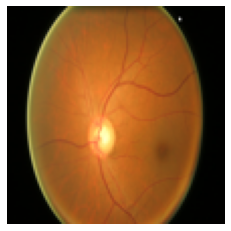

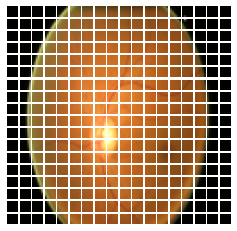

In [17]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
plt.figure(figsize=(4, 4))
image = train_ds_array[np.random.choice(range(train_ds_array.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [18]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [24]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "new2/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=train_ds_array,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
2/2 [==============================] - 63s 23s/step - loss: 27.7972 - accuracy: 0.5299 - top-5-accuracy: 1.0000 - val_loss: 15.5288 - val_accuracy: 0.7115 - val_top-5-accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 47s 19s/step - loss: 8.6581 - accuracy: 0.7372 - top-5-accuracy: 1.0000 - val_loss: 1.0100 - val_accuracy: 0.5962 - val_top-5-accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 47s 19s/step - loss: 2.3775 - accuracy: 0.6987 - top-5-accuracy: 1.0000 - val_loss: 2.2240 - val_accuracy: 0.2885 - val_top-5-accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 47s 19s/step - loss: 2.4859 - accuracy: 0.5983 - top-5-accuracy: 1.0000 - val_loss: 2.4535 - val_accuracy: 0.7115 - val_top-5-accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 47s 19s/step - loss: 1.6559 - accuracy: 0.7457 - top-5-accuracy: 1.0000 - val_loss: 1.0441 - val_accuracy: 0.3462 - val_top-5-accuracy: 1.0000
Epoch 6/10
2/2 [=================

NameError: name 'x_test' is not defined